In [1]:
import numpy as np
import pandas as pd
import torch
from config import load_config
from pathlib import Path
from lightning.pytorch.loggers.wandb import WandbLogger
from scipy.stats import wasserstein_distance, entropy
from sklearn.metrics import roc_auc_score
from tqdm import tqdm
from umap import UMAP
from matplotlib import pyplot as plt
import seaborn as sns
import faiss

# initialize the RNG deterministically
np.random.seed(42)
torch.manual_seed(42)
torch.set_float32_matmul_precision('medium')
run_stats = {}

In [2]:
# parameters
dataset_name = ""
model_name = "resnet_mse"
ood = ""

In [3]:
# Parameters
dataset_name = "QPM2_species"
ood = "2:3"


In [4]:
# initialize data attributes and loaders
config = load_config(
    dataset_name = dataset_name,
    model_name = model_name,
    ood = ood,
)
config.load_data(shuffle_training_data=False)
config.print_labels()
dm = config.datamodule

assert dm

In [5]:
# initialize data modules
dm.setup("fit")
dm.setup("test")
dm.setup("predict")

Dataset type train label type: species


Loaded 151706 images
Dataset type val label type: species


Loaded 37931 images
Dataset type test label type: species


 - Min class count:  13956
Loaded 55824 images
Dataset type test label type: species


 - Min class count:  13956
Loaded 41868 images


In [6]:
# model ids
ood_str = ":".join(map(str, config.ood))
df = pd.read_csv("ids.csv").fillna("")
model_id = df[(df.dataset_name == dataset_name) & (df.model_name == model_name) & (df.ood == ood)].id.item()
print(ood_str, model_id)

2:3 3ktwzbr5


In [7]:
# load model and weights
model = config.get_model()
artifact_dir = WandbLogger.download_artifact(artifact=f"yasith/robustml/model-{model_id}:best")
model = model.__class__.load_from_checkpoint(Path(artifact_dir) / "model.ckpt", config=config)
model = model.cuda()
model.eval();

wandb: Downloading large artifact model-3ktwzbr5:best, 58.47MB. 1 files... 


wandb:   1 of 1 files downloaded.  


Done. 0:0:6.5


In [8]:
# create data loaders
train_loader = dm.train_dataloader()
val_loader = dm.val_dataloader()
test_loader = dm.test_dataloader()
if ood_str:
    predict_loader = dm.predict_dataloader()

In [9]:
# forward pass
with torch.no_grad():
    trn_inp = []
    trn_rcn = []
    trn_emb = []
    trn_tgt = []

    val_inp = []
    val_rcn = []
    val_emb = []
    val_tgt = []

    ind_inp = []
    ind_rcn = []
    ind_emb = []
    ind_tgt = []

    if ood_str:
        ood_inp = []
        ood_rcn = []
        ood_emb = []
        ood_tgt = []

    rnd_inp = []
    rnd_rcn = []
    rnd_emb = []

    # train set (ind)
    for batch_idx, batch in enumerate(tqdm(train_loader)):
        x, y, *_ = batch
        x = x.float().cuda()
        emb, lgt, rcn = model(x)
        trn_inp.extend(x.detach().cpu().numpy())
        trn_rcn.extend(rcn.detach().cpu().numpy())
        trn_emb.extend(emb.detach().cpu().numpy())
        trn_tgt.extend(y.detach().cpu().numpy())
    print("train - OK")

    # val set (ind)
    for batch_idx, batch in enumerate(tqdm(val_loader)):
        x, y, *_ = batch
        x = x.float().cuda()
        emb, lgt, rcn = model(x)
        val_inp.extend(x.detach().cpu().numpy())
        val_rcn.extend(rcn.detach().cpu().numpy())
        val_emb.extend(emb.detach().cpu().numpy())
        val_tgt.extend(y.detach().cpu().numpy())
    print("val - OK")

    # test set (ind)
    for batch_idx, batch in enumerate(tqdm(test_loader)):
        x, y, *_ = batch
        x = x.float().cuda()
        emb, lgt, rcn = model(x)
        ind_inp.extend(x.detach().cpu().numpy())
        ind_rcn.extend(rcn.detach().cpu().numpy())
        ind_emb.extend(emb.detach().cpu().numpy())
        ind_tgt.extend(y.detach().cpu().numpy())
    print("test InD - OK")

    # predict set (ood)
    if ood_str:
        for batch_idx, batch in enumerate(tqdm(predict_loader)):
            x, y, *_ = batch
            x = x.float().cuda()
            emb, lgt, rcn = model(x)
            ood_inp.extend(x.detach().cpu().numpy())
            ood_rcn.extend(rcn.detach().cpu().numpy())
            ood_emb.extend(emb.detach().cpu().numpy())
            ood_tgt.extend(y.detach().cpu().numpy())
        print("test OoD - OK")

    # random set
    rnd_set = torch.randn(100, config.batch_size, *config.input_shape)
    for batch_idx, batch in enumerate(tqdm(rnd_set)):
        x = batch
        x = x.float().cuda()
        emb, lgt, rcn = model(x)
        rnd_inp.extend(x.detach().cpu().numpy())
        rnd_rcn.extend(rcn.detach().cpu().numpy())
        rnd_emb.extend(emb.detach().cpu().numpy())
    print("test RnD - OK")

  0%|                                                                                                                                                        | 0/1186 [00:00<?, ?it/s]

  0%|                                                                                                                                                | 1/1186 [00:01<21:31,  1.09s/it]

  1%|▋                                                                                                                                               | 6/1186 [00:01<03:01,  6.48it/s]

  1%|█▎                                                                                                                                             | 11/1186 [00:01<01:35, 12.30it/s]

  1%|█▉                                                                                                                                             | 16/1186 [00:01<01:04, 18.02it/s]

  2%|██▌                                                                                                                                            | 21/1186 [00:01<00:49, 23.30it/s]

  2%|███▏                                                                                                                                           | 26/1186 [00:01<00:41, 27.92it/s]

  3%|███▋                                                                                                                                           | 31/1186 [00:01<00:36, 31.76it/s]

  3%|████▎                                                                                                                                          | 36/1186 [00:01<00:33, 34.81it/s]

  3%|████▉                                                                                                                                          | 41/1186 [00:02<00:30, 37.14it/s]

  4%|█████▌                                                                                                                                         | 46/1186 [00:02<00:29, 38.86it/s]

  4%|██████▏                                                                                                                                        | 51/1186 [00:02<00:28, 40.03it/s]

  5%|██████▊                                                                                                                                        | 56/1186 [00:02<00:27, 40.88it/s]

  5%|███████▎                                                                                                                                       | 61/1186 [00:02<00:27, 41.48it/s]

  6%|███████▉                                                                                                                                       | 66/1186 [00:02<00:26, 41.92it/s]

  6%|████████▌                                                                                                                                      | 71/1186 [00:02<00:26, 42.24it/s]

  6%|█████████▏                                                                                                                                     | 76/1186 [00:02<00:26, 42.45it/s]

  7%|█████████▊                                                                                                                                     | 81/1186 [00:02<00:25, 42.59it/s]

  7%|██████████▎                                                                                                                                    | 86/1186 [00:03<00:25, 42.70it/s]

  8%|██████████▉                                                                                                                                    | 91/1186 [00:03<00:25, 42.78it/s]

  8%|███████████▌                                                                                                                                   | 96/1186 [00:03<00:25, 42.84it/s]

  9%|████████████                                                                                                                                  | 101/1186 [00:03<00:25, 42.91it/s]

  9%|████████████▋                                                                                                                                 | 106/1186 [00:03<00:25, 43.08it/s]

  9%|█████████████▎                                                                                                                                | 111/1186 [00:03<00:24, 43.19it/s]

 10%|█████████████▉                                                                                                                                | 116/1186 [00:03<00:24, 43.27it/s]

 10%|██████████████▍                                                                                                                               | 121/1186 [00:03<00:24, 43.32it/s]

 11%|███████████████                                                                                                                               | 126/1186 [00:03<00:24, 43.35it/s]

 11%|███████████████▋                                                                                                                              | 131/1186 [00:04<00:24, 43.37it/s]

 11%|████████████████▎                                                                                                                             | 136/1186 [00:04<00:24, 43.39it/s]

 12%|████████████████▉                                                                                                                             | 141/1186 [00:04<00:24, 43.41it/s]

 12%|█████████████████▍                                                                                                                            | 146/1186 [00:04<00:23, 43.42it/s]

 13%|██████████████████                                                                                                                            | 151/1186 [00:04<00:23, 43.45it/s]

 13%|██████████████████▋                                                                                                                           | 156/1186 [00:04<00:23, 43.35it/s]

 14%|███████████████████▎                                                                                                                          | 161/1186 [00:04<00:23, 43.38it/s]

 14%|███████████████████▉                                                                                                                          | 166/1186 [00:04<00:23, 43.40it/s]

 14%|████████████████████▍                                                                                                                         | 171/1186 [00:05<00:23, 43.43it/s]

 15%|█████████████████████                                                                                                                         | 176/1186 [00:05<00:23, 43.44it/s]

 15%|█████████████████████▋                                                                                                                        | 181/1186 [00:05<00:23, 43.45it/s]

 16%|██████████████████████▎                                                                                                                       | 186/1186 [00:05<00:23, 43.44it/s]

 16%|██████████████████████▊                                                                                                                       | 191/1186 [00:05<00:22, 43.46it/s]

 17%|███████████████████████▍                                                                                                                      | 196/1186 [00:05<00:22, 43.46it/s]

 17%|████████████████████████                                                                                                                      | 201/1186 [00:05<00:22, 43.48it/s]

 17%|████████████████████████▋                                                                                                                     | 206/1186 [00:05<00:22, 43.48it/s]

 18%|█████████████████████████▎                                                                                                                    | 211/1186 [00:05<00:22, 43.46it/s]

 18%|█████████████████████████▊                                                                                                                    | 216/1186 [00:06<00:22, 43.47it/s]

 19%|██████████████████████████▍                                                                                                                   | 221/1186 [00:06<00:22, 43.45it/s]

 19%|███████████████████████████                                                                                                                   | 226/1186 [00:06<00:22, 43.47it/s]

 19%|███████████████████████████▋                                                                                                                  | 231/1186 [00:06<00:21, 43.46it/s]

 20%|████████████████████████████▎                                                                                                                 | 236/1186 [00:06<00:21, 43.47it/s]

 20%|████████████████████████████▊                                                                                                                 | 241/1186 [00:06<00:21, 43.46it/s]

 21%|█████████████████████████████▍                                                                                                                | 246/1186 [00:06<00:21, 43.47it/s]

 21%|██████████████████████████████                                                                                                                | 251/1186 [00:06<00:21, 43.46it/s]

 22%|██████████████████████████████▋                                                                                                               | 256/1186 [00:06<00:21, 43.47it/s]

 22%|███████████████████████████████▏                                                                                                              | 261/1186 [00:07<00:21, 43.47it/s]

 22%|███████████████████████████████▊                                                                                                              | 266/1186 [00:07<00:21, 43.48it/s]

 23%|████████████████████████████████▍                                                                                                             | 271/1186 [00:07<00:21, 43.47it/s]

 23%|█████████████████████████████████                                                                                                             | 276/1186 [00:07<00:20, 43.48it/s]

 24%|█████████████████████████████████▋                                                                                                            | 281/1186 [00:07<00:20, 43.46it/s]

 24%|██████████████████████████████████▏                                                                                                           | 286/1186 [00:07<00:20, 43.47it/s]

 25%|██████████████████████████████████▊                                                                                                           | 291/1186 [00:07<00:20, 43.47it/s]

 25%|███████████████████████████████████▍                                                                                                          | 296/1186 [00:07<00:20, 43.46it/s]

 25%|████████████████████████████████████                                                                                                          | 301/1186 [00:08<00:20, 43.45it/s]

 26%|████████████████████████████████████▋                                                                                                         | 306/1186 [00:08<00:20, 43.46it/s]

 26%|█████████████████████████████████████▏                                                                                                        | 311/1186 [00:08<00:20, 43.46it/s]

 27%|█████████████████████████████████████▊                                                                                                        | 316/1186 [00:08<00:20, 43.46it/s]

 27%|██████████████████████████████████████▍                                                                                                       | 321/1186 [00:08<00:19, 43.41it/s]

 27%|███████████████████████████████████████                                                                                                       | 326/1186 [00:08<00:19, 43.43it/s]

 28%|███████████████████████████████████████▋                                                                                                      | 331/1186 [00:08<00:19, 43.45it/s]

 28%|████████████████████████████████████████▏                                                                                                     | 336/1186 [00:08<00:19, 43.45it/s]

 29%|████████████████████████████████████████▊                                                                                                     | 341/1186 [00:08<00:19, 43.45it/s]

 29%|█████████████████████████████████████████▍                                                                                                    | 346/1186 [00:09<00:19, 43.46it/s]

 30%|██████████████████████████████████████████                                                                                                    | 351/1186 [00:09<00:19, 43.46it/s]

 30%|██████████████████████████████████████████▌                                                                                                   | 356/1186 [00:09<00:19, 43.47it/s]

 30%|███████████████████████████████████████████▏                                                                                                  | 361/1186 [00:09<00:18, 43.46it/s]

 31%|███████████████████████████████████████████▊                                                                                                  | 366/1186 [00:09<00:18, 43.47it/s]

 31%|████████████████████████████████████████████▍                                                                                                 | 371/1186 [00:09<00:18, 43.46it/s]

 32%|█████████████████████████████████████████████                                                                                                 | 376/1186 [00:09<00:18, 43.46it/s]

 32%|█████████████████████████████████████████████▌                                                                                                | 381/1186 [00:09<00:18, 43.47it/s]

 33%|██████████████████████████████████████████████▏                                                                                               | 386/1186 [00:09<00:18, 43.47it/s]

 33%|██████████████████████████████████████████████▊                                                                                               | 391/1186 [00:10<00:18, 43.46it/s]

 33%|███████████████████████████████████████████████▍                                                                                              | 396/1186 [00:10<00:18, 43.47it/s]

 34%|████████████████████████████████████████████████                                                                                              | 401/1186 [00:10<00:18, 43.45it/s]

 34%|████████████████████████████████████████████████▌                                                                                             | 406/1186 [00:10<00:17, 43.43it/s]

 35%|█████████████████████████████████████████████████▏                                                                                            | 411/1186 [00:10<00:17, 43.44it/s]

 35%|█████████████████████████████████████████████████▊                                                                                            | 416/1186 [00:10<00:17, 43.45it/s]

 35%|██████████████████████████████████████████████████▍                                                                                           | 421/1186 [00:10<00:17, 43.46it/s]

 36%|███████████████████████████████████████████████████                                                                                           | 426/1186 [00:10<00:17, 43.47it/s]

 36%|███████████████████████████████████████████████████▌                                                                                          | 431/1186 [00:11<00:17, 43.47it/s]

 37%|████████████████████████████████████████████████████▏                                                                                         | 436/1186 [00:11<00:17, 43.47it/s]

 37%|████████████████████████████████████████████████████▊                                                                                         | 441/1186 [00:11<00:17, 43.47it/s]

 38%|█████████████████████████████████████████████████████▍                                                                                        | 446/1186 [00:11<00:17, 43.47it/s]

 38%|█████████████████████████████████████████████████████▉                                                                                        | 451/1186 [00:11<00:16, 43.48it/s]

 38%|██████████████████████████████████████████████████████▌                                                                                       | 456/1186 [00:11<00:16, 43.45it/s]

 39%|███████████████████████████████████████████████████████▏                                                                                      | 461/1186 [00:11<00:16, 43.45it/s]

 39%|███████████████████████████████████████████████████████▊                                                                                      | 466/1186 [00:11<00:16, 43.44it/s]

 40%|████████████████████████████████████████████████████████▍                                                                                     | 471/1186 [00:11<00:16, 43.44it/s]

 40%|████████████████████████████████████████████████████████▉                                                                                     | 476/1186 [00:12<00:16, 43.45it/s]

 41%|█████████████████████████████████████████████████████████▌                                                                                    | 481/1186 [00:12<00:16, 43.45it/s]

 41%|██████████████████████████████████████████████████████████▏                                                                                   | 486/1186 [00:12<00:16, 43.48it/s]

 41%|██████████████████████████████████████████████████████████▊                                                                                   | 491/1186 [00:12<00:15, 43.47it/s]

 42%|███████████████████████████████████████████████████████████▍                                                                                  | 496/1186 [00:12<00:15, 43.47it/s]

 42%|███████████████████████████████████████████████████████████▉                                                                                  | 501/1186 [00:12<00:15, 43.47it/s]

 43%|████████████████████████████████████████████████████████████▌                                                                                 | 506/1186 [00:12<00:15, 43.48it/s]

 43%|█████████████████████████████████████████████████████████████▏                                                                                | 511/1186 [00:12<00:15, 43.44it/s]

 44%|█████████████████████████████████████████████████████████████▊                                                                                | 516/1186 [00:12<00:15, 43.46it/s]

 44%|██████████████████████████████████████████████████████████████▍                                                                               | 521/1186 [00:13<00:15, 43.47it/s]

 44%|██████████████████████████████████████████████████████████████▉                                                                               | 526/1186 [00:13<00:15, 43.47it/s]

 45%|███████████████████████████████████████████████████████████████▌                                                                              | 531/1186 [00:13<00:15, 43.48it/s]

 45%|████████████████████████████████████████████████████████████████▏                                                                             | 536/1186 [00:13<00:14, 43.49it/s]

 46%|████████████████████████████████████████████████████████████████▊                                                                             | 541/1186 [00:13<00:14, 43.49it/s]

 46%|█████████████████████████████████████████████████████████████████▎                                                                            | 546/1186 [00:13<00:14, 43.48it/s]

 46%|█████████████████████████████████████████████████████████████████▉                                                                            | 551/1186 [00:13<00:14, 43.48it/s]

 47%|██████████████████████████████████████████████████████████████████▌                                                                           | 556/1186 [00:13<00:14, 43.48it/s]

 47%|███████████████████████████████████████████████████████████████████▏                                                                          | 561/1186 [00:13<00:14, 43.48it/s]

 48%|███████████████████████████████████████████████████████████████████▊                                                                          | 566/1186 [00:14<00:14, 43.48it/s]

 48%|████████████████████████████████████████████████████████████████████▎                                                                         | 571/1186 [00:14<00:14, 43.48it/s]

 49%|████████████████████████████████████████████████████████████████████▉                                                                         | 576/1186 [00:14<00:14, 43.46it/s]

 49%|█████████████████████████████████████████████████████████████████████▌                                                                        | 581/1186 [00:14<00:13, 43.47it/s]

 49%|██████████████████████████████████████████████████████████████████████▏                                                                       | 586/1186 [00:14<00:13, 43.48it/s]

 50%|██████████████████████████████████████████████████████████████████████▊                                                                       | 591/1186 [00:14<00:13, 43.47it/s]

 50%|███████████████████████████████████████████████████████████████████████▎                                                                      | 596/1186 [00:14<00:13, 43.46it/s]

 51%|███████████████████████████████████████████████████████████████████████▉                                                                      | 601/1186 [00:14<00:13, 43.45it/s]

 51%|████████████████████████████████████████████████████████████████████████▌                                                                     | 606/1186 [00:15<00:13, 43.46it/s]

 52%|█████████████████████████████████████████████████████████████████████████▏                                                                    | 611/1186 [00:15<00:13, 43.47it/s]

 52%|█████████████████████████████████████████████████████████████████████████▊                                                                    | 616/1186 [00:15<00:13, 43.46it/s]

 52%|██████████████████████████████████████████████████████████████████████████▎                                                                   | 621/1186 [00:15<00:12, 43.47it/s]

 53%|██████████████████████████████████████████████████████████████████████████▉                                                                   | 626/1186 [00:15<00:12, 43.47it/s]

 53%|███████████████████████████████████████████████████████████████████████████▌                                                                  | 631/1186 [00:15<00:12, 43.46it/s]

 54%|████████████████████████████████████████████████████████████████████████████▏                                                                 | 636/1186 [00:15<00:12, 43.47it/s]

 54%|████████████████████████████████████████████████████████████████████████████▋                                                                 | 641/1186 [00:15<00:12, 43.48it/s]

 54%|█████████████████████████████████████████████████████████████████████████████▎                                                                | 646/1186 [00:15<00:12, 43.44it/s]

 55%|█████████████████████████████████████████████████████████████████████████████▉                                                                | 651/1186 [00:16<00:12, 43.45it/s]

 55%|██████████████████████████████████████████████████████████████████████████████▌                                                               | 656/1186 [00:16<00:12, 43.47it/s]

 56%|███████████████████████████████████████████████████████████████████████████████▏                                                              | 661/1186 [00:16<00:12, 43.46it/s]

 56%|███████████████████████████████████████████████████████████████████████████████▋                                                              | 666/1186 [00:16<00:11, 43.45it/s]

 57%|████████████████████████████████████████████████████████████████████████████████▎                                                             | 671/1186 [00:16<00:11, 43.47it/s]

 57%|████████████████████████████████████████████████████████████████████████████████▉                                                             | 676/1186 [00:16<00:11, 43.47it/s]

 57%|█████████████████████████████████████████████████████████████████████████████████▌                                                            | 681/1186 [00:16<00:11, 43.48it/s]

 58%|██████████████████████████████████████████████████████████████████████████████████▏                                                           | 686/1186 [00:16<00:11, 43.48it/s]

 58%|██████████████████████████████████████████████████████████████████████████████████▋                                                           | 691/1186 [00:16<00:11, 43.48it/s]

 59%|███████████████████████████████████████████████████████████████████████████████████▎                                                          | 696/1186 [00:17<00:11, 43.48it/s]

 59%|███████████████████████████████████████████████████████████████████████████████████▉                                                          | 701/1186 [00:17<00:11, 43.49it/s]

 60%|████████████████████████████████████████████████████████████████████████████████████▌                                                         | 706/1186 [00:17<00:11, 43.48it/s]

 60%|█████████████████████████████████████████████████████████████████████████████████████▏                                                        | 711/1186 [00:17<00:10, 43.47it/s]

 60%|█████████████████████████████████████████████████████████████████████████████████████▋                                                        | 716/1186 [00:17<00:10, 43.48it/s]

 61%|██████████████████████████████████████████████████████████████████████████████████████▎                                                       | 721/1186 [00:17<00:10, 43.47it/s]

 61%|██████████████████████████████████████████████████████████████████████████████████████▉                                                       | 726/1186 [00:17<00:10, 43.47it/s]

 62%|███████████████████████████████████████████████████████████████████████████████████████▌                                                      | 731/1186 [00:17<00:10, 43.43it/s]

 62%|████████████████████████████████████████████████████████████████████████████████████████                                                      | 736/1186 [00:18<00:10, 43.43it/s]

 62%|████████████████████████████████████████████████████████████████████████████████████████▋                                                     | 741/1186 [00:18<00:10, 43.42it/s]

 63%|█████████████████████████████████████████████████████████████████████████████████████████▎                                                    | 746/1186 [00:18<00:10, 43.44it/s]

 63%|█████████████████████████████████████████████████████████████████████████████████████████▉                                                    | 751/1186 [00:18<00:10, 43.44it/s]

 64%|██████████████████████████████████████████████████████████████████████████████████████████▌                                                   | 756/1186 [00:18<00:09, 43.46it/s]

 64%|███████████████████████████████████████████████████████████████████████████████████████████                                                   | 761/1186 [00:18<00:09, 43.47it/s]

 65%|███████████████████████████████████████████████████████████████████████████████████████████▋                                                  | 766/1186 [00:18<00:09, 43.48it/s]

 65%|████████████████████████████████████████████████████████████████████████████████████████████▎                                                 | 771/1186 [00:18<00:09, 43.48it/s]

 65%|████████████████████████████████████████████████████████████████████████████████████████████▉                                                 | 776/1186 [00:18<00:09, 43.49it/s]

 66%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                                | 781/1186 [00:19<00:09, 43.48it/s]

 66%|██████████████████████████████████████████████████████████████████████████████████████████████                                                | 786/1186 [00:19<00:09, 43.46it/s]

 67%|██████████████████████████████████████████████████████████████████████████████████████████████▋                                               | 791/1186 [00:19<00:09, 43.46it/s]

 67%|███████████████████████████████████████████████████████████████████████████████████████████████▎                                              | 796/1186 [00:19<00:08, 43.48it/s]

 68%|███████████████████████████████████████████████████████████████████████████████████████████████▉                                              | 801/1186 [00:19<00:08, 43.47it/s]

 68%|████████████████████████████████████████████████████████████████████████████████████████████████▌                                             | 806/1186 [00:19<00:08, 43.47it/s]

 68%|█████████████████████████████████████████████████████████████████████████████████████████████████                                             | 811/1186 [00:19<00:08, 43.46it/s]

 69%|█████████████████████████████████████████████████████████████████████████████████████████████████▋                                            | 816/1186 [00:19<00:08, 43.45it/s]

 69%|██████████████████████████████████████████████████████████████████████████████████████████████████▎                                           | 821/1186 [00:19<00:08, 43.41it/s]

 70%|██████████████████████████████████████████████████████████████████████████████████████████████████▉                                           | 826/1186 [00:20<00:08, 43.43it/s]

 70%|███████████████████████████████████████████████████████████████████████████████████████████████████▍                                          | 831/1186 [00:20<00:08, 43.45it/s]

 70%|████████████████████████████████████████████████████████████████████████████████████████████████████                                          | 836/1186 [00:20<00:08, 43.46it/s]

 71%|████████████████████████████████████████████████████████████████████████████████████████████████████▋                                         | 841/1186 [00:20<00:07, 43.46it/s]

 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎                                        | 846/1186 [00:20<00:07, 43.46it/s]

 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉                                        | 851/1186 [00:20<00:07, 43.46it/s]

 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍                                       | 856/1186 [00:20<00:07, 43.46it/s]

 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████                                       | 861/1186 [00:20<00:07, 43.47it/s]

 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋                                      | 866/1186 [00:21<00:07, 43.47it/s]

 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                     | 871/1186 [00:21<00:07, 43.46it/s]

 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                     | 876/1186 [00:21<00:07, 43.47it/s]

 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                    | 881/1186 [00:21<00:07, 43.37it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████                                    | 886/1186 [00:21<00:06, 43.41it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                   | 891/1186 [00:21<00:06, 43.43it/s]

 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                  | 896/1186 [00:21<00:06, 43.44it/s]

 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                  | 901/1186 [00:21<00:06, 43.45it/s]

 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                 | 906/1186 [00:21<00:06, 43.45it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████                                 | 911/1186 [00:22<00:06, 43.46it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                | 916/1186 [00:22<00:06, 43.47it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                               | 921/1186 [00:22<00:06, 43.41it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                               | 926/1186 [00:22<00:05, 43.44it/s]

 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                              | 931/1186 [00:22<00:05, 43.46it/s]

 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████                              | 936/1186 [00:22<00:05, 43.46it/s]

 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                             | 941/1186 [00:22<00:05, 43.46it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                            | 946/1186 [00:22<00:05, 43.44it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                            | 951/1186 [00:22<00:05, 43.39it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                           | 956/1186 [00:23<00:05, 43.31it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████                           | 961/1186 [00:23<00:05, 43.21it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                          | 966/1186 [00:23<00:05, 43.14it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                         | 971/1186 [00:23<00:04, 43.11it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                         | 976/1186 [00:23<00:04, 43.08it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                        | 981/1186 [00:23<00:04, 43.06it/s]

 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                        | 986/1186 [00:23<00:04, 43.05it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 991/1186 [00:23<00:04, 43.04it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                      | 996/1186 [00:24<00:04, 43.02it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                      | 1001/1186 [00:24<00:04, 43.01it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                     | 1006/1186 [00:24<00:04, 43.11it/s]

 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                    | 1011/1186 [00:24<00:04, 43.20it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                    | 1016/1186 [00:24<00:03, 43.27it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                   | 1021/1186 [00:24<00:03, 43.33it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                   | 1026/1186 [00:24<00:03, 43.40it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                  | 1031/1186 [00:24<00:03, 43.43it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                 | 1036/1186 [00:24<00:03, 43.45it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                 | 1041/1186 [00:25<00:03, 43.40it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                | 1046/1186 [00:25<00:03, 43.44it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                | 1051/1186 [00:25<00:03, 43.46it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌               | 1056/1186 [00:25<00:02, 43.47it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏              | 1061/1186 [00:25<00:02, 43.49it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋              | 1066/1186 [00:25<00:02, 43.50it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎             | 1071/1186 [00:25<00:02, 43.50it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉             | 1076/1186 [00:25<00:02, 43.52it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌            | 1081/1186 [00:25<00:02, 43.51it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████            | 1086/1186 [00:26<00:02, 43.50it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋           | 1091/1186 [00:26<00:02, 43.51it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎          | 1096/1186 [00:26<00:02, 43.50it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉          | 1101/1186 [00:26<00:01, 43.51it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍         | 1106/1186 [00:26<00:01, 43.49it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████         | 1111/1186 [00:26<00:01, 43.50it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋        | 1116/1186 [00:26<00:01, 43.50it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎       | 1121/1186 [00:26<00:01, 43.50it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊       | 1126/1186 [00:27<00:01, 43.49it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 1131/1186 [00:27<00:01, 43.50it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████      | 1136/1186 [00:27<00:01, 43.51it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋     | 1141/1186 [00:27<00:01, 43.51it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 1146/1186 [00:27<00:00, 43.51it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊    | 1151/1186 [00:27<00:00, 43.45it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 1156/1186 [00:27<00:00, 43.47it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████   | 1161/1186 [00:27<00:00, 43.47it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌  | 1166/1186 [00:27<00:00, 43.47it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 1171/1186 [00:28<00:00, 43.40it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊ | 1176/1186 [00:28<00:00, 43.43it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍| 1181/1186 [00:28<00:00, 43.36it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1186/1186 [00:28<00:00, 41.55it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1186/1186 [00:28<00:00, 41.72it/s]

train - OK


  0%|                                                                                                                                                         | 0/297 [00:00<?, ?it/s]

  0%|▍                                                                                                                                                | 1/297 [00:00<01:25,  3.46it/s]

  2%|██▉                                                                                                                                              | 6/297 [00:00<00:16, 17.82it/s]

  4%|█████▎                                                                                                                                          | 11/297 [00:00<00:10, 26.46it/s]

  5%|███████▊                                                                                                                                        | 16/297 [00:00<00:08, 31.91it/s]

  7%|█████████▋                                                                                                                                      | 20/297 [00:00<00:08, 33.97it/s]

  8%|████████████                                                                                                                                    | 25/297 [00:00<00:07, 36.91it/s]

 10%|██████████████▌                                                                                                                                 | 30/297 [00:00<00:06, 38.88it/s]

 12%|████████████████▉                                                                                                                               | 35/297 [00:01<00:06, 40.22it/s]

 13%|███████████████████▍                                                                                                                            | 40/297 [00:01<00:06, 41.15it/s]

 15%|█████████████████████▊                                                                                                                          | 45/297 [00:01<00:06, 41.79it/s]

 17%|████████████████████████▏                                                                                                                       | 50/297 [00:01<00:05, 42.20it/s]

 19%|██████████████████████████▋                                                                                                                     | 55/297 [00:01<00:05, 42.50it/s]

 20%|█████████████████████████████                                                                                                                   | 60/297 [00:01<00:05, 42.68it/s]

 22%|███████████████████████████████▌                                                                                                                | 65/297 [00:01<00:05, 42.83it/s]

 24%|█████████████████████████████████▉                                                                                                              | 70/297 [00:01<00:05, 42.95it/s]

 25%|████████████████████████████████████▎                                                                                                           | 75/297 [00:02<00:05, 43.04it/s]

 27%|██████████████████████████████████████▊                                                                                                         | 80/297 [00:02<00:05, 43.11it/s]

 29%|█████████████████████████████████████████▏                                                                                                      | 85/297 [00:02<00:04, 43.15it/s]

 30%|███████████████████████████████████████████▋                                                                                                    | 90/297 [00:02<00:04, 43.18it/s]

 32%|██████████████████████████████████████████████                                                                                                  | 95/297 [00:02<00:04, 43.18it/s]

 34%|████████████████████████████████████████████████▏                                                                                              | 100/297 [00:02<00:04, 43.21it/s]

 35%|██████████████████████████████████████████████████▌                                                                                            | 105/297 [00:02<00:04, 43.23it/s]

 37%|████████████████████████████████████████████████████▉                                                                                          | 110/297 [00:02<00:04, 43.22it/s]

 39%|███████████████████████████████████████████████████████▎                                                                                       | 115/297 [00:02<00:04, 43.23it/s]

 40%|█████████████████████████████████████████████████████████▊                                                                                     | 120/297 [00:03<00:04, 43.22it/s]

 42%|████████████████████████████████████████████████████████████▏                                                                                  | 125/297 [00:03<00:03, 43.23it/s]

 44%|██████████████████████████████████████████████████████████████▌                                                                                | 130/297 [00:03<00:03, 43.24it/s]

 45%|█████████████████████████████████████████████████████████████████                                                                              | 135/297 [00:03<00:03, 43.24it/s]

 47%|███████████████████████████████████████████████████████████████████▍                                                                           | 140/297 [00:03<00:03, 43.24it/s]

 49%|█████████████████████████████████████████████████████████████████████▊                                                                         | 145/297 [00:03<00:03, 43.22it/s]

 51%|████████████████████████████████████████████████████████████████████████▏                                                                      | 150/297 [00:03<00:03, 43.23it/s]

 52%|██████████████████████████████████████████████████████████████████████████▋                                                                    | 155/297 [00:03<00:03, 43.16it/s]

 54%|█████████████████████████████████████████████████████████████████████████████                                                                  | 160/297 [00:03<00:03, 43.06it/s]

 56%|███████████████████████████████████████████████████████████████████████████████▍                                                               | 165/297 [00:04<00:03, 42.99it/s]

 57%|█████████████████████████████████████████████████████████████████████████████████▊                                                             | 170/297 [00:04<00:02, 42.94it/s]

 59%|████████████████████████████████████████████████████████████████████████████████████▎                                                          | 175/297 [00:04<00:02, 42.98it/s]

 61%|██████████████████████████████████████████████████████████████████████████████████████▋                                                        | 180/297 [00:04<00:02, 42.97it/s]

 62%|█████████████████████████████████████████████████████████████████████████████████████████                                                      | 185/297 [00:04<00:02, 43.04it/s]

 64%|███████████████████████████████████████████████████████████████████████████████████████████▍                                                   | 190/297 [00:04<00:02, 43.08it/s]

 66%|█████████████████████████████████████████████████████████████████████████████████████████████▉                                                 | 195/297 [00:04<00:02, 43.12it/s]

 67%|████████████████████████████████████████████████████████████████████████████████████████████████▎                                              | 200/297 [00:04<00:02, 43.06it/s]

 69%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                                            | 205/297 [00:05<00:02, 43.08it/s]

 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████                                          | 210/297 [00:05<00:02, 43.13it/s]

 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌                                       | 215/297 [00:05<00:01, 43.18it/s]

 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                     | 220/297 [00:05<00:01, 43.20it/s]

 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                  | 225/297 [00:05<00:01, 43.17it/s]

 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                | 230/297 [00:05<00:01, 43.13it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                             | 235/297 [00:05<00:01, 43.04it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                           | 240/297 [00:05<00:01, 42.97it/s]

 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                         | 245/297 [00:05<00:01, 43.02it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                      | 250/297 [00:06<00:01, 43.04it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                    | 255/297 [00:06<00:00, 43.08it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                 | 260/297 [00:06<00:00, 43.14it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌               | 265/297 [00:06<00:00, 43.18it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████             | 270/297 [00:06<00:00, 43.19it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍          | 275/297 [00:06<00:00, 43.22it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 280/297 [00:06<00:00, 43.22it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏     | 285/297 [00:06<00:00, 43.21it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 290/297 [00:06<00:00, 43.20it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████ | 295/297 [00:07<00:00, 43.11it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 297/297 [00:07<00:00, 40.71it/s]

val - OK


  0%|                                                                                                                                                         | 0/437 [00:00<?, ?it/s]

  0%|▎                                                                                                                                                | 1/437 [00:00<02:26,  2.98it/s]

  1%|█▉                                                                                                                                               | 6/437 [00:00<00:26, 16.22it/s]

  3%|███▌                                                                                                                                            | 11/437 [00:00<00:17, 24.88it/s]

  4%|█████▎                                                                                                                                          | 16/437 [00:00<00:13, 30.70it/s]

  5%|██████▉                                                                                                                                         | 21/437 [00:00<00:11, 34.67it/s]

  6%|████████▌                                                                                                                                       | 26/437 [00:00<00:11, 37.33it/s]

  7%|██████████▏                                                                                                                                     | 31/437 [00:01<00:10, 39.11it/s]

  8%|███████████▊                                                                                                                                    | 36/437 [00:01<00:09, 40.39it/s]

  9%|█████████████▌                                                                                                                                  | 41/437 [00:01<00:09, 41.26it/s]

 11%|███████████████▏                                                                                                                                | 46/437 [00:01<00:09, 41.86it/s]

 12%|████████████████▊                                                                                                                               | 51/437 [00:01<00:09, 42.29it/s]

 13%|██████████████████▍                                                                                                                             | 56/437 [00:01<00:08, 42.70it/s]

 14%|████████████████████                                                                                                                            | 61/437 [00:01<00:08, 42.93it/s]

 15%|█████████████████████▋                                                                                                                          | 66/437 [00:01<00:08, 43.08it/s]

 16%|███████████████████████▍                                                                                                                        | 71/437 [00:01<00:08, 43.24it/s]

 17%|█████████████████████████                                                                                                                       | 76/437 [00:02<00:08, 43.30it/s]

 19%|██████████████████████████▋                                                                                                                     | 81/437 [00:02<00:08, 43.32it/s]

 20%|████████████████████████████▎                                                                                                                   | 86/437 [00:02<00:08, 43.34it/s]

 21%|█████████████████████████████▉                                                                                                                  | 91/437 [00:02<00:07, 43.35it/s]

 22%|███████████████████████████████▋                                                                                                                | 96/437 [00:02<00:07, 43.33it/s]

 23%|█████████████████████████████████                                                                                                              | 101/437 [00:02<00:07, 43.35it/s]

 24%|██████████████████████████████████▋                                                                                                            | 106/437 [00:02<00:07, 43.33it/s]

 25%|████████████████████████████████████▎                                                                                                          | 111/437 [00:02<00:07, 43.32it/s]

 27%|█████████████████████████████████████▉                                                                                                         | 116/437 [00:02<00:07, 43.34it/s]

 28%|███████████████████████████████████████▌                                                                                                       | 121/437 [00:03<00:07, 43.31it/s]

 29%|█████████████████████████████████████████▏                                                                                                     | 126/437 [00:03<00:07, 43.33it/s]

 30%|██████████████████████████████████████████▊                                                                                                    | 131/437 [00:03<00:07, 43.34it/s]

 31%|████████████████████████████████████████████▌                                                                                                  | 136/437 [00:03<00:06, 43.33it/s]

 32%|██████████████████████████████████████████████▏                                                                                                | 141/437 [00:03<00:06, 43.34it/s]

 33%|███████████████████████████████████████████████▊                                                                                               | 146/437 [00:03<00:06, 43.35it/s]

 35%|█████████████████████████████████████████████████▍                                                                                             | 151/437 [00:03<00:06, 43.34it/s]

 36%|███████████████████████████████████████████████████                                                                                            | 156/437 [00:03<00:06, 43.32it/s]

 37%|████████████████████████████████████████████████████▋                                                                                          | 161/437 [00:04<00:06, 43.33it/s]

 38%|██████████████████████████████████████████████████████▎                                                                                        | 166/437 [00:04<00:06, 43.34it/s]

 39%|███████████████████████████████████████████████████████▉                                                                                       | 171/437 [00:04<00:06, 43.36it/s]

 40%|█████████████████████████████████████████████████████████▌                                                                                     | 176/437 [00:04<00:06, 43.32it/s]

 41%|███████████████████████████████████████████████████████████▏                                                                                   | 181/437 [00:04<00:05, 43.33it/s]

 43%|████████████████████████████████████████████████████████████▊                                                                                  | 186/437 [00:04<00:05, 43.33it/s]

 44%|██████████████████████████████████████████████████████████████▌                                                                                | 191/437 [00:04<00:05, 43.34it/s]

 45%|████████████████████████████████████████████████████████████████▏                                                                              | 196/437 [00:04<00:05, 43.30it/s]

 46%|█████████████████████████████████████████████████████████████████▊                                                                             | 201/437 [00:04<00:05, 43.28it/s]

 47%|███████████████████████████████████████████████████████████████████▍                                                                           | 206/437 [00:05<00:05, 43.23it/s]

 48%|█████████████████████████████████████████████████████████████████████                                                                          | 211/437 [00:05<00:05, 43.21it/s]

 49%|██████████████████████████████████████████████████████████████████████▋                                                                        | 216/437 [00:05<00:05, 43.21it/s]

 51%|████████████████████████████████████████████████████████████████████████▎                                                                      | 221/437 [00:05<00:05, 43.15it/s]

 52%|█████████████████████████████████████████████████████████████████████████▉                                                                     | 226/437 [00:05<00:04, 43.18it/s]

 53%|███████████████████████████████████████████████████████████████████████████▌                                                                   | 231/437 [00:05<00:04, 43.16it/s]

 54%|█████████████████████████████████████████████████████████████████████████████▏                                                                 | 236/437 [00:05<00:04, 43.17it/s]

 55%|██████████████████████████████████████████████████████████████████████████████▊                                                                | 241/437 [00:05<00:04, 43.19it/s]

 56%|████████████████████████████████████████████████████████████████████████████████▍                                                              | 246/437 [00:05<00:04, 43.21it/s]

 57%|██████████████████████████████████████████████████████████████████████████████████▏                                                            | 251/437 [00:06<00:04, 43.17it/s]

 59%|███████████████████████████████████████████████████████████████████████████████████▊                                                           | 256/437 [00:06<00:04, 43.20it/s]

 60%|█████████████████████████████████████████████████████████████████████████████████████▍                                                         | 261/437 [00:06<00:04, 43.19it/s]

 61%|███████████████████████████████████████████████████████████████████████████████████████                                                        | 266/437 [00:06<00:03, 43.17it/s]

 62%|████████████████████████████████████████████████████████████████████████████████████████▋                                                      | 271/437 [00:06<00:03, 43.23it/s]

 63%|██████████████████████████████████████████████████████████████████████████████████████████▎                                                    | 276/437 [00:06<00:03, 43.25it/s]

 64%|███████████████████████████████████████████████████████████████████████████████████████████▉                                                   | 281/437 [00:06<00:03, 43.21it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                                 | 286/437 [00:06<00:03, 43.29it/s]

 67%|███████████████████████████████████████████████████████████████████████████████████████████████▏                                               | 291/437 [00:07<00:03, 43.26it/s]

 68%|████████████████████████████████████████████████████████████████████████████████████████████████▊                                              | 296/437 [00:07<00:03, 43.26it/s]

 69%|██████████████████████████████████████████████████████████████████████████████████████████████████▍                                            | 301/437 [00:07<00:03, 43.29it/s]

 70%|████████████████████████████████████████████████████████████████████████████████████████████████████▏                                          | 306/437 [00:07<00:03, 43.30it/s]

 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊                                         | 311/437 [00:07<00:02, 43.31it/s]

 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍                                       | 316/437 [00:07<00:02, 43.30it/s]

 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████                                      | 321/437 [00:07<00:02, 43.28it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                    | 326/437 [00:07<00:02, 43.28it/s]

 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                  | 331/437 [00:07<00:02, 43.29it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                 | 336/437 [00:08<00:02, 43.22it/s]

 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                               | 341/437 [00:08<00:02, 43.14it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                             | 346/437 [00:08<00:02, 43.11it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                            | 351/437 [00:08<00:01, 43.12it/s]

 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                          | 356/437 [00:08<00:01, 43.20it/s]

 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                        | 361/437 [00:08<00:01, 43.21it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                       | 366/437 [00:08<00:01, 43.28it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                     | 371/437 [00:08<00:01, 43.32it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                    | 376/437 [00:08<00:01, 43.34it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                  | 381/437 [00:09<00:01, 43.33it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                | 386/437 [00:09<00:01, 43.35it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉               | 391/437 [00:09<00:01, 43.36it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌             | 396/437 [00:09<00:00, 43.37it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏           | 401/437 [00:09<00:00, 43.36it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊          | 406/437 [00:09<00:00, 43.34it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 411/437 [00:09<00:00, 43.14it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 416/437 [00:09<00:00, 43.20it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 421/437 [00:10<00:00, 43.25it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 426/437 [00:10<00:00, 43.28it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████  | 431/437 [00:10<00:00, 43.25it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋| 436/437 [00:10<00:00, 43.21it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 437/437 [00:10<00:00, 41.36it/s]

test InD - OK


  0%|                                                                                                                                                         | 0/328 [00:00<?, ?it/s]

  0%|▍                                                                                                                                                | 1/328 [00:00<02:07,  2.57it/s]

  2%|██▋                                                                                                                                              | 6/328 [00:00<00:21, 14.65it/s]

  3%|████▊                                                                                                                                           | 11/328 [00:00<00:13, 23.14it/s]

  5%|███████                                                                                                                                         | 16/328 [00:00<00:10, 29.14it/s]

  6%|█████████▏                                                                                                                                      | 21/328 [00:00<00:09, 33.35it/s]

  8%|███████████▍                                                                                                                                    | 26/328 [00:00<00:08, 36.20it/s]

  9%|█████████████▌                                                                                                                                  | 31/328 [00:01<00:07, 38.26it/s]

 11%|███████████████▊                                                                                                                                | 36/328 [00:01<00:07, 39.71it/s]

 12%|██████████████████                                                                                                                              | 41/328 [00:01<00:07, 40.74it/s]

 14%|████████████████████▏                                                                                                                           | 46/328 [00:01<00:06, 41.47it/s]

 16%|██████████████████████▍                                                                                                                         | 51/328 [00:01<00:06, 41.95it/s]

 17%|████████████████████████▌                                                                                                                       | 56/328 [00:01<00:06, 42.31it/s]

 19%|██████████████████████████▊                                                                                                                     | 61/328 [00:01<00:06, 42.57it/s]

 20%|████████████████████████████▉                                                                                                                   | 66/328 [00:01<00:06, 42.73it/s]

 22%|███████████████████████████████▏                                                                                                                | 71/328 [00:02<00:05, 42.85it/s]

 23%|█████████████████████████████████▎                                                                                                              | 76/328 [00:02<00:05, 42.94it/s]

 25%|███████████████████████████████████▌                                                                                                            | 81/328 [00:02<00:05, 42.98it/s]

 26%|█████████████████████████████████████▊                                                                                                          | 86/328 [00:02<00:05, 43.00it/s]

 28%|███████████████████████████████████████▉                                                                                                        | 91/328 [00:02<00:05, 43.05it/s]

 29%|██████████████████████████████████████████▏                                                                                                     | 96/328 [00:02<00:05, 42.89it/s]

 31%|████████████████████████████████████████████                                                                                                   | 101/328 [00:02<00:05, 42.97it/s]

 32%|██████████████████████████████████████████████▏                                                                                                | 106/328 [00:02<00:05, 43.00it/s]

 34%|████████████████████████████████████████████████▍                                                                                              | 111/328 [00:02<00:05, 43.03it/s]

 35%|██████████████████████████████████████████████████▌                                                                                            | 116/328 [00:03<00:04, 43.06it/s]

 37%|████████████████████████████████████████████████████▊                                                                                          | 121/328 [00:03<00:04, 43.07it/s]

 38%|██████████████████████████████████████████████████████▉                                                                                        | 126/328 [00:03<00:04, 43.09it/s]

 40%|█████████████████████████████████████████████████████████                                                                                      | 131/328 [00:03<00:04, 43.10it/s]

 41%|███████████████████████████████████████████████████████████▎                                                                                   | 136/328 [00:03<00:04, 43.11it/s]

 43%|█████████████████████████████████████████████████████████████▍                                                                                 | 141/328 [00:03<00:04, 43.12it/s]

 45%|███████████████████████████████████████████████████████████████▋                                                                               | 146/328 [00:03<00:04, 43.11it/s]

 46%|█████████████████████████████████████████████████████████████████▊                                                                             | 151/328 [00:03<00:04, 43.12it/s]

 48%|████████████████████████████████████████████████████████████████████                                                                           | 156/328 [00:03<00:03, 43.09it/s]

 49%|██████████████████████████████████████████████████████████████████████▏                                                                        | 161/328 [00:04<00:03, 43.10it/s]

 51%|████████████████████████████████████████████████████████████████████████▎                                                                      | 166/328 [00:04<00:03, 42.59it/s]

 52%|██████████████████████████████████████████████████████████████████████████▌                                                                    | 171/328 [00:04<00:03, 42.75it/s]

 54%|████████████████████████████████████████████████████████████████████████████▋                                                                  | 176/328 [00:04<00:03, 42.83it/s]

 55%|██████████████████████████████████████████████████████████████████████████████▉                                                                | 181/328 [00:04<00:03, 42.91it/s]

 57%|█████████████████████████████████████████████████████████████████████████████████                                                              | 186/328 [00:04<00:03, 42.98it/s]

 58%|███████████████████████████████████████████████████████████████████████████████████▎                                                           | 191/328 [00:04<00:03, 43.01it/s]

 60%|█████████████████████████████████████████████████████████████████████████████████████▍                                                         | 196/328 [00:04<00:03, 43.02it/s]

 61%|███████████████████████████████████████████████████████████████████████████████████████▋                                                       | 201/328 [00:05<00:02, 43.04it/s]

 63%|█████████████████████████████████████████████████████████████████████████████████████████▊                                                     | 206/328 [00:05<00:02, 43.07it/s]

 64%|███████████████████████████████████████████████████████████████████████████████████████████▉                                                   | 211/328 [00:05<00:02, 43.10it/s]

 66%|██████████████████████████████████████████████████████████████████████████████████████████████▏                                                | 216/328 [00:05<00:02, 43.10it/s]

 67%|████████████████████████████████████████████████████████████████████████████████████████████████▎                                              | 221/328 [00:05<00:02, 43.06it/s]

 69%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                                            | 226/328 [00:05<00:02, 43.09it/s]

 70%|████████████████████████████████████████████████████████████████████████████████████████████████████▋                                          | 231/328 [00:05<00:02, 43.10it/s]

 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉                                        | 236/328 [00:05<00:02, 43.10it/s]

 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████                                      | 241/328 [00:05<00:02, 43.01it/s]

 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                   | 246/328 [00:06<00:01, 43.04it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                 | 251/328 [00:06<00:01, 42.98it/s]

 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                               | 256/328 [00:06<00:01, 43.04it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                             | 261/328 [00:06<00:01, 43.07it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                           | 266/328 [00:06<00:01, 43.09it/s]

 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                        | 271/328 [00:06<00:01, 43.10it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                      | 276/328 [00:06<00:01, 43.12it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                    | 281/328 [00:06<00:01, 43.10it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                  | 286/328 [00:07<00:00, 43.15it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                | 291/328 [00:07<00:00, 43.15it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████              | 296/328 [00:07<00:00, 43.15it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏           | 301/328 [00:07<00:00, 43.15it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍         | 306/328 [00:07<00:00, 43.14it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌       | 311/328 [00:07<00:00, 43.13it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 316/328 [00:07<00:00, 43.14it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 321/328 [00:07<00:00, 43.06it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏| 326/328 [00:07<00:00, 43.02it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 328/328 [00:08<00:00, 40.18it/s]

test OoD - OK


  0%|                                                                                                                                                         | 0/100 [00:00<?, ?it/s]

  5%|███████▎                                                                                                                                         | 5/100 [00:00<00:02, 44.42it/s]

 10%|██████████████▍                                                                                                                                 | 10/100 [00:00<00:02, 44.48it/s]

 15%|█████████████████████▌                                                                                                                          | 15/100 [00:00<00:01, 44.60it/s]

 20%|████████████████████████████▊                                                                                                                   | 20/100 [00:00<00:01, 44.68it/s]

 25%|████████████████████████████████████                                                                                                            | 25/100 [00:00<00:01, 44.75it/s]

 30%|███████████████████████████████████████████▏                                                                                                    | 30/100 [00:00<00:01, 44.79it/s]

 35%|██████████████████████████████████████████████████▍                                                                                             | 35/100 [00:00<00:01, 44.82it/s]

 40%|█████████████████████████████████████████████████████████▌                                                                                      | 40/100 [00:00<00:01, 44.84it/s]

 45%|████████████████████████████████████████████████████████████████▊                                                                               | 45/100 [00:01<00:01, 44.85it/s]

 50%|████████████████████████████████████████████████████████████████████████                                                                        | 50/100 [00:01<00:01, 44.87it/s]

 55%|███████████████████████████████████████████████████████████████████████████████▏                                                                | 55/100 [00:01<00:01, 44.88it/s]

 60%|██████████████████████████████████████████████████████████████████████████████████████▍                                                         | 60/100 [00:01<00:00, 44.88it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                                  | 65/100 [00:01<00:00, 44.89it/s]

 70%|████████████████████████████████████████████████████████████████████████████████████████████████████▊                                           | 70/100 [00:01<00:00, 44.89it/s]

 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████                                    | 75/100 [00:01<00:00, 44.91it/s]

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                            | 80/100 [00:01<00:00, 44.91it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                     | 85/100 [00:01<00:00, 44.91it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌              | 90/100 [00:02<00:00, 44.91it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊       | 95/100 [00:02<00:00, 44.91it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 44.91it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 44.83it/s]

test RnD - OK


In [10]:
# create numpy arrays
trn_inp = np.array(trn_inp)
trn_rcn = np.array(trn_rcn)
trn_emb = np.array(trn_emb).squeeze()
trn_tgt = np.array(trn_tgt)

val_inp = np.array(val_inp)
val_rcn = np.array(val_rcn)
val_emb = np.array(val_emb).squeeze()
val_tgt = np.array(val_tgt)

ind_inp = np.array(ind_inp)
ind_rcn = np.array(ind_rcn)
ind_emb = np.array(ind_emb).squeeze()
ind_tgt = np.array(ind_tgt)

if ood_str:
    ood_inp = np.array(ood_inp)
    ood_rcn = np.array(ood_rcn)
    ood_emb = np.array(ood_emb).squeeze()
    ood_tgt = np.array(ood_tgt)

rnd_inp = np.array(rnd_inp)
rnd_rcn = np.array(rnd_rcn)
rnd_emb = np.array(rnd_emb).squeeze()

ind_labels = [config.labels[i] for i in ind_tgt]
if ood_str:
    ood_labels = [config.labels[i] for i in ood_tgt]

print(trn_inp.shape, trn_rcn.shape, trn_emb.shape, trn_tgt.shape)
print(val_inp.shape, val_rcn.shape, val_emb.shape, val_tgt.shape)
print(ind_inp.shape, ind_rcn.shape, ind_emb.shape, ind_tgt.shape)
if ood_str:
    print(ood_inp.shape, ood_rcn.shape, ood_emb.shape, ood_tgt.shape)
print(rnd_inp.shape, rnd_rcn.shape, rnd_emb.shape)

(151706, 1, 64, 64) (151706, 1, 64, 64) (151706, 512) (151706,)
(37931, 1, 64, 64) (37931, 1, 64, 64) (37931, 512) (37931,)
(55824, 1, 64, 64) (55824, 1, 64, 64) (55824, 512) (55824,)
(41868, 1, 64, 64) (41868, 1, 64, 64) (41868, 512) (41868,)
(12800, 1, 64, 64) (12800, 1, 64, 64) (12800, 512)


In [11]:
# create 2d embeddings
n = ind_emb.shape[0]
all_emb = ind_emb
if ood_str:
    all_emb = np.concatenate([all_emb, ood_emb], axis=0)

umap = UMAP(n_components=2, random_state=42)
all_emb2d = umap.fit_transform(all_emb)
ind_emb2d = np.array(all_emb2d[:n], order='C').astype(np.float32)
ood_emb2d = np.array(all_emb2d[n:], order='C').astype(np.float32)
print(ind_emb2d.shape, ood_emb2d.shape)

/n/home12/yasith/.conda/envs/qpm-amrb/lib/python3.10/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


(55824, 2) (41868, 2)


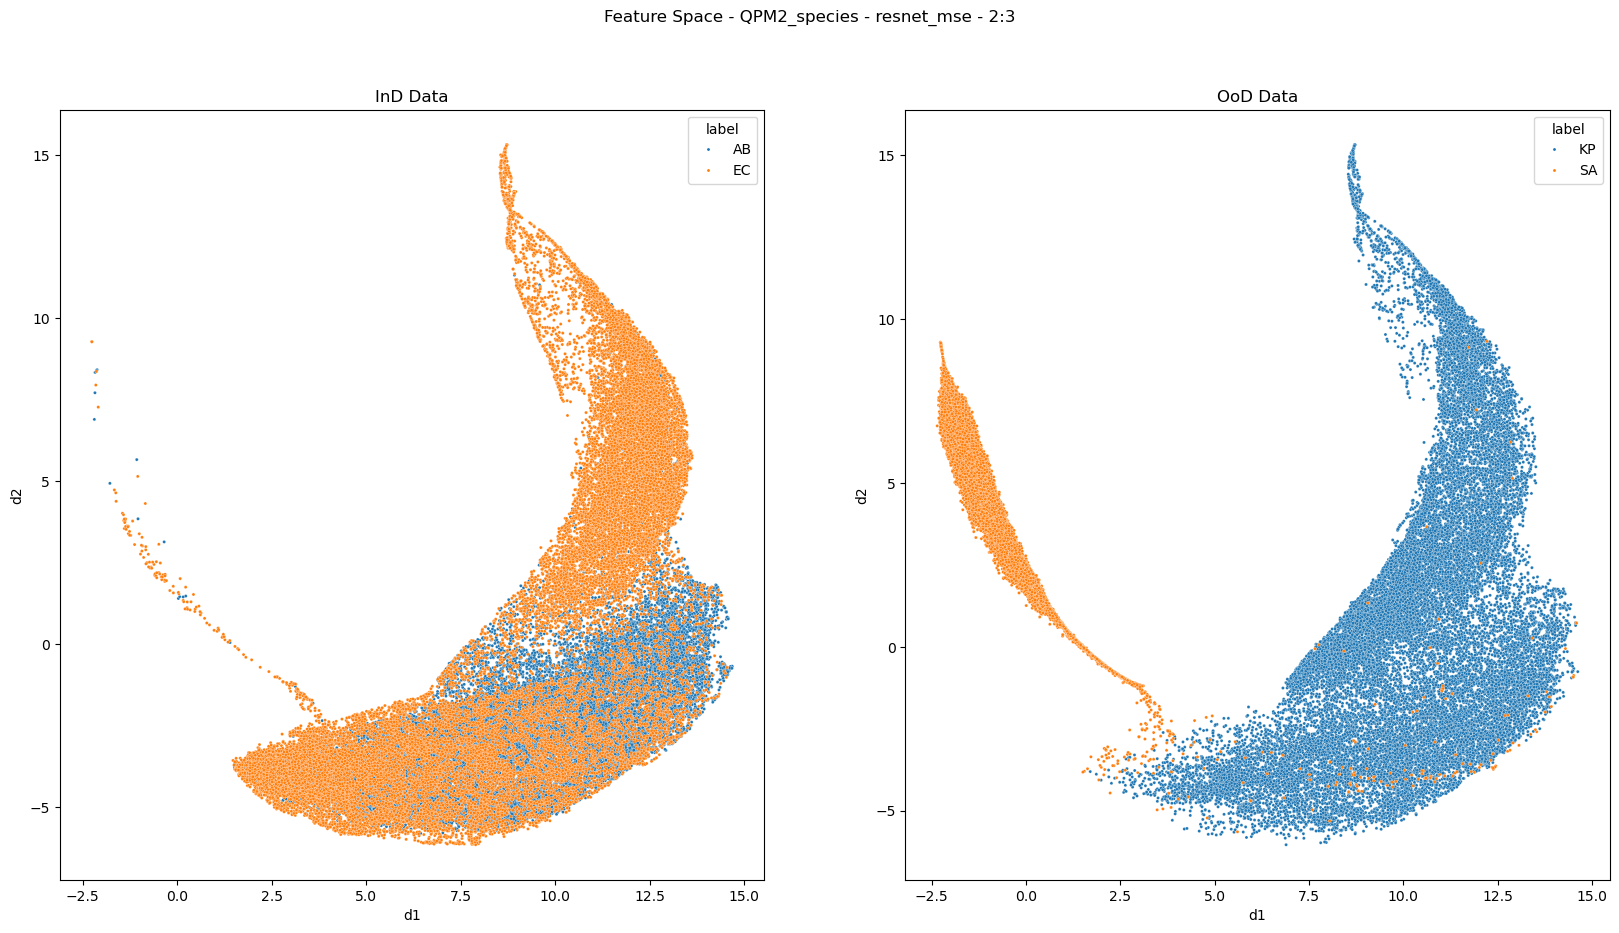

In [12]:
# plot feature space
df_emb2d = pd.DataFrame()
d1, d2 = ind_emb2d.T
df_emb2d = pd.concat([df_emb2d, pd.DataFrame(dict(d1=d1, d2=d2, label=ind_labels, source="ind"))])

if ood_str:
    d1, d2 = ood_emb2d.T
    df_emb2d = pd.concat([df_emb2d, pd.DataFrame(dict(d1=d1, d2=d2, label=ood_labels, source="ood"))])

fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(20, 10))
fig.suptitle(f"Feature Space - {dataset_name} - {model_name} - {ood_str}")
sns.scatterplot(data=df_emb2d[(df_emb2d['source'] == "ind")], x="d1", y="d2", hue="label", s=5, ax=ax1)
ax1.set_title("InD Data")
sns.scatterplot(data=df_emb2d[(df_emb2d['source'] == "ood")], x="d1", y="d2", hue="label", s=5, ax=ax2)
ax2.set_title("OoD Data")
plt.show()

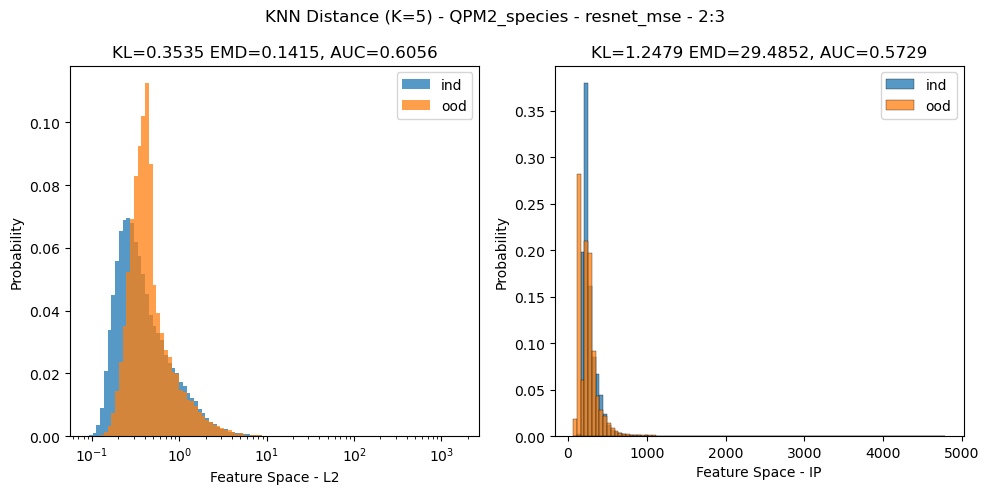

In [13]:
# plot knn distance from ind/ood to val data
def plot_knn_dists(index_fn, ax, trn_data, val_data, ind_data, ood_data=None, k=5, scale="linspace"):
    stats = {}
    index = index_fn(trn_data.shape[-1])
    index.add(trn_data)
    Dv = index.search(val_data, k)[0].mean(-1)
    Di = index.search(ind_data, k)[0].mean(-1)
    D = [Di]
    T = [[0] * Di.shape[0]]
    if ood_str:
        Do = index.search(ood_data, k)[0].mean(-1)
        D.append(Do)
        T.append([1] * Do.shape[0]) 
    D = np.concatenate(D, axis=0)
    T = np.concatenate(T, axis=0)
    if scale == "linspace":
        s, e = D.min(), D.max()
        bins = np.linspace(s, e, 100)
    if scale == "logspace":
        s, e = np.log10(D.min() + 1e-7), np.log10(D.max())
        bins = np.logspace(s, e, 100)
    sns.histplot(Di, fill=True, label='ind', stat='probability', ax=ax, bins=bins)
    prefix = ""
    if ood_str:
        Ci = np.histogram(Di, bins, density=True)[0]
        Co = np.histogram(Do, bins, density=True)[0]
        kld = entropy(Co + 1e-7, Ci + 1e-7)
        emd = wasserstein_distance(Do, Di)
        auc = roc_auc_score(T, D)
        auc = max(auc, 1-auc)
        sns.histplot(Do, fill=True, label='ood', stat='probability', ax=ax, bins=bins)
        ax.set_title(f"KL={kld:.4f} EMD={emd:.4f}, AUC={auc:.4f}")
        stats.update(dict(kld=kld, emd=emd, auc=auc, val_data=Dv.tolist(), ind_data=Di.tolist(), ood_data=Do.tolist()))
        
    if scale == "logspace":
        ax.set_xscale('log')
    ax.legend()
    return stats

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
fig.suptitle(f"KNN Distance (K=5) - {dataset_name} - {model_name} - {ood_str}")
run_stats["knn_f_l2"] = plot_knn_dists(faiss.IndexFlatL2, axs[0], trn_emb, val_emb, ind_emb, ood_emb if ood_str else None, scale="logspace")
axs[0].set_xlabel("Feature Space - L2")
run_stats["knn_f_ip"] = plot_knn_dists(faiss.IndexFlatIP, axs[1], trn_emb, val_emb, ind_emb, ood_emb if ood_str else None, scale="linspace")
axs[1].set_xlabel("Feature Space - IP")
plt.tight_layout()
plt.show()

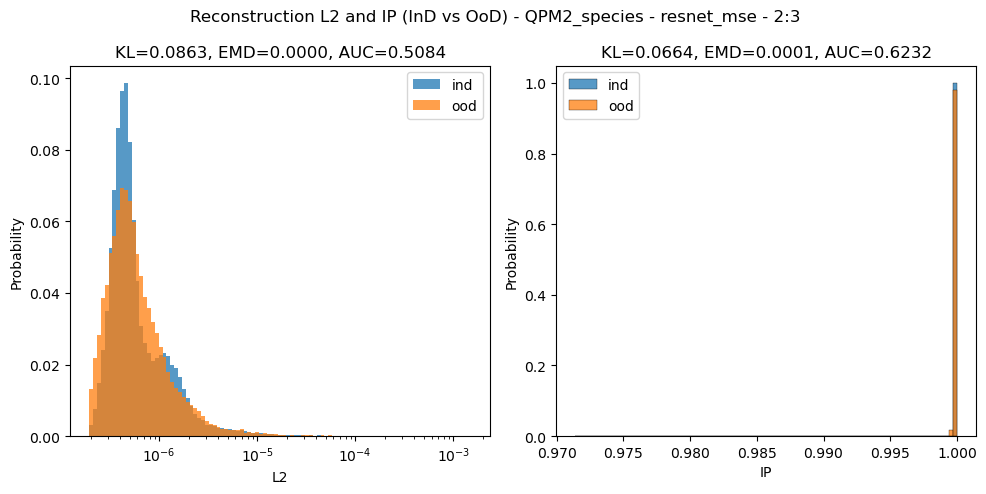

In [14]:
# plot reconstruction error of ind and ood data
def plot_rcn(val_rcn, ind_rcn, ood_rcn, ax, scale="linspace"):
    stats = {}
    D = ind_rcn
    if ood_str:
        D = np.concatenate([ind_rcn, ood_rcn], axis=0)
    if scale == "linspace":
        s, e = D.min(), D.max()
        bins = np.linspace(s, e, 100)
    if scale == "logspace":
        s, e = np.log10(D.min() + 1e-7), np.log10(D.max())
        bins = np.logspace(s, e, 100)
    sns.histplot(ind_rcn, label="ind", stat="probability", bins=bins, ax=ax)
    if ood_str:
        sns.histplot(ood_rcn, label="ood", stat="probability", bins=bins, ax=ax)
        T = np.concatenate([[0]*ind_rcn.shape[0],[1]*ood_rcn.shape[0]], axis=0)
        Ci = np.histogram(ind_rcn, bins, density=True)[0]
        Co = np.histogram(ood_rcn, bins, density=True)[0]
        kld = entropy(Co + 1e-7, Ci + 1e-7)
        emd = wasserstein_distance(ood_rcn, ind_rcn)
        auc = roc_auc_score(T, D)
        auc = max(auc, 1-auc)
        ax.set_title(f"KL={kld:.4f}, EMD={emd:.4f}, AUC={auc:.4f}")
        stats.update(dict(kld=kld, emd=emd, auc=auc, val_data=val_rcn.tolist(), ind_data=ind_rcn.tolist(), ood_data=ood_rcn.tolist()))
    if scale == "logspace":
        ax.set_xscale("log")
    ax.legend()
    return stats

flatten = lambda x: x.reshape((x.shape[0], -1))
unit = lambda x: x / (np.linalg.norm(x, axis=-1, keepdims=True) + 1e-7)

# training data
_val_inp, _val_rcn = flatten(val_inp), flatten(val_rcn)
_val_inp_unit, _val_rcn_unit = unit(_val_inp), unit(_val_rcn)
# metrics
val_rcn_l2 = ((_val_inp - _val_rcn) ** 2).mean(-1)
val_rcn_ip = (_val_inp_unit * _val_rcn_unit).sum(-1)

# ind test data
_ind_inp, _ind_rcn = flatten(ind_inp), flatten(ind_rcn)
_ind_inp_unit, _ind_rcn_unit = unit(_ind_inp), unit(_ind_rcn)
# metrics
ind_rcn_l2 = ((_ind_inp - _ind_rcn) ** 2).mean(-1)
ind_rcn_ip = (_ind_inp_unit * _ind_rcn_unit).sum(-1)

if ood_str:
    # ood test data
    _ood_inp, _ood_rcn = flatten(ood_inp), flatten(ood_rcn)
    _ood_inp_unit, _ood_rcn_unit = unit(_ood_inp), unit(_ood_rcn)
    # metrics
    ood_rcn_l2 = ((_ood_inp - _ood_rcn) ** 2).mean(-1)
    ood_rcn_ip = (_ood_inp_unit * _ood_rcn_unit).sum(-1)

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
run_stats["rcn_l2"] = plot_rcn(val_rcn_l2, ind_rcn_l2, ood_rcn_l2 if ood_str else None, ax1, scale="logspace")
ax1.set_xlabel("L2")
run_stats["rcn_ip"] = plot_rcn(val_rcn_ip, ind_rcn_ip, ood_rcn_ip if ood_str else None, ax2, scale="linspace")
ax2.set_xlabel("IP")
plt.suptitle(f"Reconstruction L2 and IP (InD vs OoD) - {dataset_name} - {model_name} - {ood_str}")
plt.tight_layout()
plt.show()

In [15]:
run_stats.update(dict(dataset_name=dataset_name, model_name=model_name, ood=ood))
import json
from datetime import datetime
with open(f"assets/results/{datetime.now()}.json", "w") as f:
    json.dump(run_stats, f)